In [1]:
import numpy as np, os
import matplotlib.pyplot as plt
import pandas as pd, random
import torch, torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from torch.optim import SGD, AdamW
from torch.utils import data
import pytorch_lightning as pl
from pl_bolts.optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision import transforms, models
from sklearn.metrics import classification_report


In [2]:
!pip install lightning-bolts


Defaulting to user installation because normal site-packages is not writeable


In [3]:
def train_test_split(path):
    train_path = path + "train_images/"
    train_list = [os.path.join(train_path, img) for img in os.listdir(train_path)]
    random.shuffle(train_list)
    threshold = int(0.8 * len(train_list))
    valid_list = train_list[threshold:]
    train_list = train_list[:threshold]
    test_path = path + "test_images/"
    test_list = [os.path.join(test_path, img) for img in os.listdir(test_path)]
    return train_list, valid_list, test_list

In [4]:
path = 'physionet.org/files/vindr-spinexr/tiny_vindr/'
train, valid, test = train_test_split(path)
annotations = pd.read_csv(path + "/annotations/train.csv")
train_annot = [
    annotations.iloc[idx] for idx, row in enumerate(annotations.iterrows()) \
        if "{}train_images/{}.jpg".format(path, row[1]["image_id"]) in train
]
train_annot = pd.DataFrame(train_annot).drop_duplicates(subset=["image_id"]).sort_values(by=["image_id"])
valid_annot = [
    annotations.iloc[idx] for idx, row in enumerate(annotations.iterrows()) \
        if "{}train_images/{}.jpg".format(path, row[1]["image_id"]) in valid
]
valid_annot = pd.DataFrame(valid_annot).drop_duplicates(subset=["image_id"]).sort_values(by=["image_id"])
annotations = pd.read_csv(path + "/annotations/test.csv")
test_annot = [
    annotations.iloc[idx] for idx, row in enumerate(annotations.iterrows()) \
        if "{}test_images/{}.jpg".format(path, row[1]["image_id"]) in test
]
test_annot = pd.DataFrame(test_annot).drop_duplicates(subset=["image_id"]).sort_values(by=["image_id"])

In [ ]:
class VinDrSpineXR(data.Dataset):
    def __init__(self, root_dir, annot_df, transform=None):
        self.img_paths = root_dir
        self.img_paths.sort()
        self.transform = transform
        self.labels = annot_df[["image_id", "lesion_type"]]
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        image = Image.open(self.img_paths[idx])
        #  0: Abnormal  |  1: Normal
        label = self.labels.iloc[idx, 1] == "No finding"
        image = self.transform(image)
        return image, label*1
contrastive_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop(size=(224,224)),
                                          transforms.RandomApply([
                                              transforms.ColorJitter(brightness=(0.2),
                                                                     contrast=0.2,
                                                                     saturation=0.2,
                                                                     hue=0.1)
                                          ], p=0.8),
                                          transforms.RandomRotation(45),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                         ])
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
batch_size = 32
num_workers=8

train_dataset = VinDrSpineXR(train, train_annot, contrastive_transform)
valid_dataset = VinDrSpineXR(valid, valid_annot, contrastive_transform)
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=num_workers)
valid_loader = data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False,num_workers=num_workers)


In [7]:
class SimCLR(pl.LightningModule):

    def __init__(self, n_classes,use_pretrained=True, freeze=True,temperature=0.1,weight_decay=1e-6,lr=0.1,max_epochs=50):
        super().__init__()
        self.save_hyperparameters()
        self.lr = lr
        self.max_epochs =max_epochs
        self.weight_decay = 1e-6
        self.tou = temperature
        #change to 50
        self.backbone = models.resnet18(pretrained=True) 
        n_feats = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(nn.Linear(n_feats, n_feats),nn.ReLU(),nn.Linear(n_feats, n_classes))
        
    def contrastive_loss(self,batch,mode='train'):
        images,_ = batch
        images = torch.cat((images,images), dim=0)
        data = self.backbone(images)
        similarity_matrix = F.cosine_similarity(data[None,:,:],data[:,None,:],dim=-1).to(device)
        mask = torch.eye(similarity_matrix.size()[0]).to(device)
        similarity_matrix = similarity_matrix.masked_fill(mask==1,-9e15)
        pos_mask = mask.roll(shifts=similarity_matrix.shape[0]//2, dims=0)
        num = torch.exp((pos_mask*similarity_matrix)/self.tou)
        one = torch.ones(pos_mask.size())
        neg_mask = one - pos_mask
        denom = torch.sum(neg_mask * num,dim=0)
        loss = -torch.log(num/denom)
#         self.log(f'{mode}_loss: {loss}')
        return loss.mean()

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.lr)
    #   optimizer = LARS(
    #             params,
    #             lr=self.lr,
    #             momentum=0.9,
    #             weight_decay=self.weight_decay,
    #             trust_coefficient=0.001,
    #         )
      

        scheduler = LinearWarmupCosineAnnealingLR(optimizer, warmup_epochs=10, max_epochs=self.max_epochs,
                                                         warmup_start_lr=0.0)

        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):

        return self.contrastive_loss(batch,mode='train')

    def validation_step(self, batch, batch_idx):
        self.contrastive_loss(batch, mode='val')


In [8]:
#hyperparams
weight_decay =1e-6
learning_rate =0.1
n_epochs=1
temperature=0.1
n_classes=2

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimCLR(n_classes, use_pretrained=True, freeze=False,temperature=temperature,weight_decay=weight_decay,lr=0.1,max_epochs=n_epochs).to(device)


In [ ]:

save_model_path = os.path.join(os.getcwd(), "saved_models/")
filename='SimCLR_ResNet50_adam_'
save_name = filename + '.ckpt'
checkpoint_callback = ModelCheckpoint(filename=filename, dirpath=save_model_path,every_n_epochs=1,
                                        save_last=True, save_top_k=2,monitor='Contrastive loss_epoch',mode='min')
def train_simclr(model, max_epochs, train_loader,val_loader,pretrained_checkpoint):
    trainer = pl.Trainer(callbacks=[checkpoint_callback],
                  gpus=1 if str(device)=='cuda:0' else 0,
                  max_epochs=max_epochs) 

    # pretrained_filename = os.path.join(CHECKPOINT_PATH, 'SimCLR.ckpt')
    # if os.path.isfile(pretrained_filename):
    #     print(f'Found pretrained model at {pretrained_filename}, loading...')
    #     model = SimCLR.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    # else:
    model = SimCLR.load_from_checkpoint(pretrained_checkpoint,strict=False)
    pl.seed_everything(42)
    trainer.fit(model, train_loader, val_loader)
    model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    return model


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42
Missing logger folder: /scratch1/vsomayaj/lightning_logs

  | Name     | Type   | Params
------------------------------------
0 | backbone | ResNet | 11.4 M
------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.761    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home1/vsomayaj/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:486: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/home1/vsomayaj/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home1/vsomayaj/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the num

Training: 0it [00:00, ?it/s]

In [ ]:
pretrained_checkpoint = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt'
train_simclr(model,n_epochs, train_loader,valid_loader,pretrained_checkpoint)

In [ ]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = np.array(img.permute(1,2,0))
        axs[0, i].imshow(img)
        
def show_tranformed_image(loader,number):
    images, targets = next(iter(loader))
    images = list(image for image in images)
    for image in images[:number]:
        show(image)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


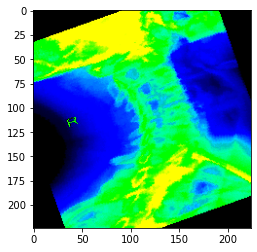

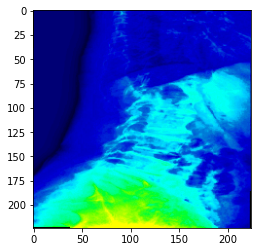

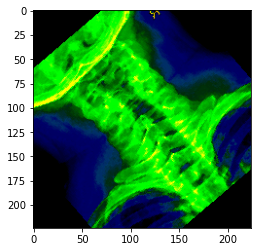

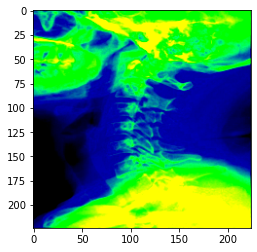

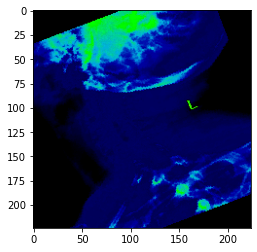

In [61]:
show_tranformed_image(train_loader,5)

In [ ]:
checkpoint_path = 'saved_models/SimCLR_ResNet50_adam_.ckpt'
model.load_state_dict(torch.load(filepath))

In [ ]:
supervised_train_dataset = VinDrSpineXR(train, train_annot,train_transform)
train_loader = data.DataLoader(supervised_train_dataset, batch_size=batch_size, shuffle=True,num_workers=num_workers)

supervised_val_dataset = VinDrSpineXR(valid, valid_annot,train_transform)
valid_loader = data.DataLoader(supervised_val_dataset, batch_size=batch_size, shuffle=False,num_workers=num_workers)

supervised_test_dataset = VinDrSpineXR(test, test_annot,test_transform)
test_loader = data.DataLoader(supervised_test_dataset, batch_size=batch_size, shuffle=False,num_workers=num_workers)

In [ ]:
#### Build and Train Network Model
class XRModel(nn.Module):
    def __init__(self, pretrained_model,n_classes, use_pretrained=False, freeze=True):
        super(XRModel, self).__init__()
        self.base_net = pretrained_model
        if freeze:
            for child in self.base_net.children():
                for param in child.parameters():
                    param.requires_grad = False
        n_feats = self.base_net.classifier.in_features
        self.base_net.classifier = nn.Linear(n_feats, 256)
        self.cls = nn.Sequential(nn.LeakyReLU(), nn.Linear(256, n_classes))
    def forward(self, input):
        return self.cls(self.base_net(input))

In [ ]:
fine_tune_model = XRModel(pretrained_model=model,n_classes=2, freeze=False).to(device)
optim = AdamW(fine_tune_model.parameters(), lr=1e-3)
lossf = nn.CrossEntropyLoss()
n_epochs = 1

In [ ]:
for i in range(1, n_epochs+1):
    print(f"\nEpoch {i}:")
    print("-"*10)
    running_loss, running_hits = 0.0, 0.0
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optim.zero_grad()
        with torch.set_grad_enabled(True):
            out = fine_tune_model(images)
            loss = lossf(out, labels)
            _, pred = torch.max(out, 1)
            loss.backward()
            optim.step()
    
        running_loss += loss.item()
        #running_hits += torch.true_divide(torch.sum(pred == labels),len(labels))
        running_hits += (torch.sum(pred == labels)).item() / batch_size
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc  = running_hits / len(train_loader)
    print("Train Loss: {:.3f}\t Acc: {:.3f}".format(epoch_loss, epoch_acc))
    
    running_loss, running_hits = 0.0, 0.0
    for images, labels in tqdm(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        with torch.set_grad_enabled(False):
            out = model(images)
            loss = lossf(out, labels)
            _, pred = torch.max(out, 1)
    
        running_loss += loss.item()
        #running_hits += torch.true_divide(torch.sum(pred == labels),len(labels))
        running_hits += (torch.sum(pred == labels)).item() / batch_size
        
    epoch_loss = running_loss / len(valid_loader)
    epoch_acc  = running_hits / len(valid_loader)
    print("Valid Loss: {:.3f}\t Acc: {:.3f}".format(epoch_loss, epoch_acc))

In [ ]:
torch.save(model, path + "model.pt")

In [ ]:
predictions, trues = [], []
with torch.set_grad_enabled(False):
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        out = model(images)
        _, pred = torch.max(out, 1)
        predictions.append(pred)
        trues.append(labels)
        
predictions = torch.cat(predictions).detach().cpu().numpy()
trues = torch.cat(trues).detach().cpu().numpy()
print(classification_report(trues, predictions))